<img src=https://upload.wikimedia.org/wikipedia/commons/thumb/4/47/Logo_UTFSM.png/250px-Logo_UTFSM.png style="float:right;height:90px">
<img src=http://carla2014.ccarla.org/img/logo_DI_UTFSM.jpg style="float:left;height:90px">
<center>
    <h1> Scientific Programming in Python  </h1>
    <h2> Actividad 6 </h2> 
</center>

<center>    
    Roberto Felipe Fuentes Zenteno - `roberto.fuentes@alumnos.usm.cl`.
</center>

In [1]:
import numba
import numexpr as ne
import numpy as np
import matplotlib.pyplot as roberplot
import matplotlib.image as mpimg

%load_ext Cython

%load_ext line_profiler
%load_ext memory_profiler

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def image_plot(img):
    roberplot.figure(figsize=(10,5))
    roberplot.imshow(img, cmap='gray')
    roberplot.axis('off')
    roberplot.show()
    
def histogram_plot(h):
    roberplot.figure(figsize=(5,10))
    roberplot.plot(range(len(h)), h)
    roberplot.xlim([-5,260])
    roberplot.ylim([0,200000])
    roberplot.xlabel('Feature index')
    roberplot.ylabel('Number of repetitions')
    roberplot.grid()
    roberplot.show()

## Local Binary Pattern Representation

Local Binary Pattern (LBP) is a simple yet very efficient texture operator which labels the pixels of an image by thresholding the neighborhood of each pixel and considers the result as a binary number. 

Due to its discriminative power and computational simplicity, LBP texture operator has become a popular approach in various applications. 

Perhaps the most important property of the LBP operator in real-world applications is its robustness to monotonic gray-scale changes caused, for example, by illumination variations. Another important property is its computational simplicity, which makes it possible to analyze images in challenging real-time settings.

__Example of how LBP works:__
![image](data/lbp1.png)

__Type of features LBP compute:__
![image](data/lbp2.png)

Then, each pixel in the image is encoded as a 8-bit binary number (or its corresponding decimal representation) which represents a unique feature. With this representation we can make a histogram of the distribution of such features!

In [2]:
def lbp(region):
    """
    Region is a 3x3 ndarray
    """
    ret = (region > region[1,1]).astype(int)
    return (2**7)*ret[0,0] + (2**6)*ret[0,1] + (2**5)*ret[0,2] + (2**4)*ret[1,2] + (2**3)*ret[2,2] + \
           (2**2)*ret[2,1] + (2**1)*ret[2,0] + (2**0)*ret[1,0]


def lbp_representation(image):
    """
    Compute lbp representation of image
    """
    m,n = image.shape
    ret = np.empty((m-2,n-2))
    for i in range(1,m-1):
        for j in range(1,n-1):
            ret[i-1,j-1] = lbp(image[i-1:i+2, j-1:j+2])
    return ret


def lbp_histogram(image):
    """
    Compute lbp histogram representation of image
    """
    lbp_image = lbp_representation(image)
    m,n = lbp_image.shape
    hist = np.zeros(256)
    for i in range(m):
        for j in range(n):
            hist[int(lbp_image[i,j])] += 1
    return hist 

## Just an example of usage

In [3]:
img = mpimg.imread('data/doge.jpg')
img = rgb2gray(img)

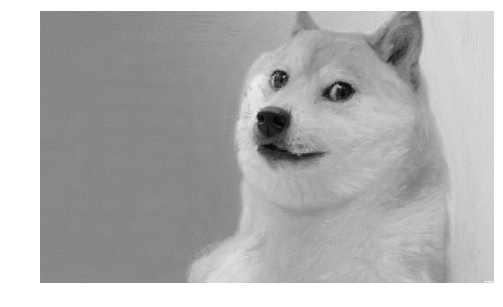

In [4]:
image_plot(img)

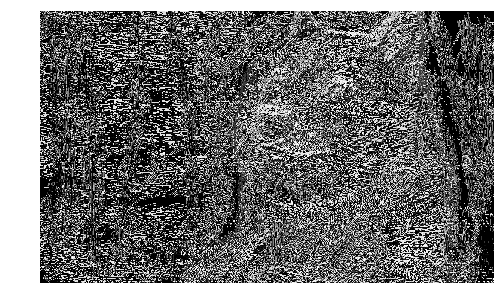

In [5]:
lbp_image = lbp_representation(img)
image_plot(lbp_image)

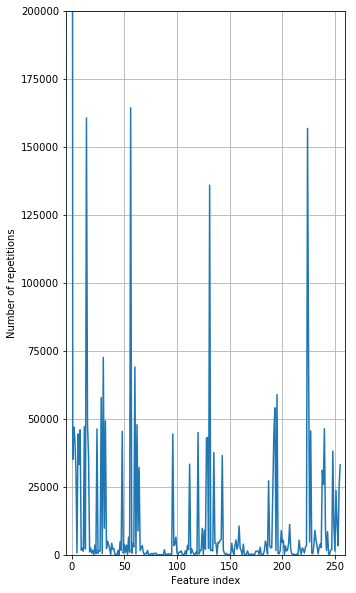

In [6]:
h = lbp_histogram(img)
histogram_plot(h)

## Problems
1. Profile the function `lbp_histogram()` with the profiling tools that you think are useful for this problem, and find the bottleneck(s).
2. Modify or implement new functions to fix such bottlenecks. You can use any of the tools learned so far (__NumPy, Numba, Cython, NumExpr, etc).__
3. Profile again (with your modifications) and verify that there exist improvements.

## Desarrollo

Primero procedemos a hacer el _profiling_ de nuestra función <code> lbp_histogram() </code>:

In [7]:
%%prun -s cumulative -q -l 15 -T prun0
lbp_histogram(img)

 
*** Profile printout saved to text file 'prun0'. 


In [8]:
print(open('prun0', 'r').read())

         7150183 function calls in 32.035 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   32.035   32.035 {built-in method builtins.exec}
        1    0.003    0.003   32.035   32.035 <string>:2(<module>)
        1    3.109    3.109   32.032   32.032 <ipython-input-2-177f652754f3>:21(lbp_histogram)
        1    4.665    4.665   28.923   28.923 <ipython-input-2-177f652754f3>:9(lbp_representation)
  3575088   21.700    0.000   24.255    0.000 <ipython-input-2-177f652754f3>:1(lbp)
  3575088    2.555    0.000    2.555    0.000 {method 'astype' of 'numpy.ndarray' objects}
        1    0.002    0.002    0.002    0.002 {built-in method numpy.core.multiarray.empty}
        1    0.000    0.000    0.000    0.000 {built-in method numpy.core.multiarray.zeros}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}


Nos damos cuenta por el _tottime_ que la función que más se demora es <code>lbp()</code>. Luego procedemos a hacer un __`line_profile`__  de esta función: 

In [9]:
m,n = img.shape
%lprun -T lprof2 -f lbp lbp(img[0:3, 0:3])


*** Profile printout saved to text file 'lprof2'. 


In [10]:
print(open('lprof2', 'r').read())

Timer unit: 1e-06 s

Total time: 5.1e-05 s
File: <ipython-input-2-177f652754f3>
Function: lbp at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def lbp(region):
     2                                               """
     3                                               Region is a 3x3 ndarray
     4                                               """
     5         1           41     41.0     80.4      ret = (region > region[1,1]).astype(int)
     6         1           10     10.0     19.6      return (2**7)*ret[0,0] + (2**6)*ret[0,1] + (2**5)*ret[0,2] + (2**4)*ret[1,2] + (2**3)*ret[2,2] +            (2**2)*ret[2,1] + (2**1)*ret[2,0] + (2**0)*ret[1,0]


Vemos que la mayor parte del tiempo se lo lleva la linea donde se hace la asignación <code>ret = (region > region[1,1]).astype(int) </code>, por lo que redefinimos la función usando _numba_:

In [11]:
@numba.jit('int64 (float64[:,:])', nopython=True)
def lbp(region):
    """
    Region is a 3x3 ndarray
    """     
    ret = (region > region[1,1])
    return (2**7)*ret[0,0] + (2**6)*ret[0,1] + (2**5)*ret[0,2] + (2**4)*ret[1,2] + (2**3)*ret[2,2] + \
           (2**2)*ret[2,1] + (2**1)*ret[2,0] + (2**0)*ret[1,0]

Luego procedemos a ejecutar nuevamente la función, viendo su _profiling_:

In [12]:
%%prun -s cumulative -q -l 15 -T prun0
lbp_histogram(img)

 
*** Profile printout saved to text file 'prun0'. 


In [13]:
print(open('prun0', 'r').read())

         3575130 function calls (3575128 primitive calls) in 11.888 seconds

   Ordered by: cumulative time
   List reduced from 34 to 15 due to restriction <15>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   11.888   11.888 {built-in method builtins.exec}
        1    0.003    0.003   11.888   11.888 <string>:2(<module>)
        1    2.833    2.833   11.885   11.885 <ipython-input-2-177f652754f3>:21(lbp_histogram)
        1    7.327    7.327    9.051    9.051 <ipython-input-2-177f652754f3>:9(lbp_representation)
  3575088    1.722    0.000    1.722    0.000 <ipython-input-11-9a452f0e56c7>:1(lbp)
        1    0.003    0.003    0.003    0.003 {built-in method numpy.core.multiarray.empty}
        1    0.000    0.000    0.000    0.000 dispatcher.py:420(typeof_pyval)
        1    0.000    0.000    0.000    0.000 typeof.py:22(typeof)
        1    0.000    0.000    0.000    0.000 functools.py:744(wrapper)
        1    0.000    0.000    0

Nos damos cuenta de que el tiempo total de la función bajo claramente de 32 segundos a 11 segundos aproximadamente, tiempo mucho mas razonable que lo mostrado por el _profiling_ anterior. Nos damos cuenta además que la otra función que ocupa bastante tiempo es  <code>lbp_representation()</code>. Sabiendo esto, veremos el __`line_profile`__:

In [14]:
@numba.jit('float64[:,:] (float64[:,:])', nopython=True)
def lbp_representation(image):
    """
    Compute lbp representation of image
    """
    m,n = image.shape
    ret = np.empty((m-2,n-2))
    for i in range(1,m-1):
        for j in range(1,n-1):
            ret[i-1,j-1] = lbp(image[i-1:i+2, j-1:j+2])
    return ret

Finalmente procedemos a ejecutar nuevamente la función y ver su _profiling_:

In [15]:
%%prun -s cumulative -q -l 15 -T prun0
lbp_histogram(img)

 
*** Profile printout saved to text file 'prun0'. 


In [16]:
print(open('prun0', 'r').read())

         124 function calls (112 primitive calls) in 3.506 seconds

   Ordered by: cumulative time
   List reduced from 46 to 15 due to restriction <15>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    3.506    3.506 {built-in method builtins.exec}
        1    0.003    0.003    3.506    3.506 <string>:2(<module>)
        1    2.828    2.828    3.503    3.503 <ipython-input-2-177f652754f3>:21(lbp_histogram)
        1    0.675    0.675    0.675    0.675 <ipython-input-14-99696d3fc760>:1(lbp_representation)
        2    0.000    0.000    0.000    0.000 dispatcher.py:420(typeof_pyval)
        2    0.000    0.000    0.000    0.000 typeof.py:22(typeof)
        1    0.000    0.000    0.000    0.000 dispatcher.py:401(_search_new_conversions)
        2    0.000    0.000    0.000    0.000 functools.py:744(wrapper)
        2    0.000    0.000    0.000    0.000 typeof.py:190(_typeof_ndarray)
        2    0.000    0.000    0.000    0.000 abstr

Finalmente nos damos cuenta que el tiempo de ejecución bajo de 11 segundos a 3 segundos aproximadamente, tiempo considerablemente bajo en comparación al primer _profiling_, el cual fue de 32 segundos.